# Part II (Analytical Option Formulae)
On `1-Dec-2020`, the S\&P 500 (SPX) index value was 3662.45, while the SPDR S\&P 500 Exchange Traded Fund (SPY) stock price was 366.02. The call and put option prices (bid \& offer) over 3 maturities are provided in the spreadsheet:
- `SPX_options.csv`,
- `SPY_options.csv`.

The discount rate on this day is in the file: `zero_rates_20201201.csv`. Calibrate the following models to match the option prices:
- Displaced-diffusion model,
- SABR model (fix $\beta = 0.7$).

Plot the fitted implied volatility smile against the market data. Report the model parameters:
1. $\sigma$, $\beta$,
2. $\alpha$, $\rho$, $\nu$,

and discuss how changing $\beta$ in the displaced-diffusion model and changing $\rho$ and $\nu$ in the SABR model affect the shape of the implied volatility smile.

# Response
We start by importing and analyzing the following items needed for our data analysis:

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import brentq, least_squares
import sys

sys.path.append("..")

from option_types.vanilla_option import VanillaOption

plt.style.use("classic")

# 1. Data Preparation


In [5]:
df_spx = pd.read_csv("SPX_options.csv")
df_spy = pd.read_csv("SPY_options.csv")
df_rates = pd.read_csv("zero_rates_20201201.csv")

S_SPX = 3662.45
S_SPY = 366.02

In [6]:
def process_rates_data(df):
    def convert_datetime(df):
        df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")

    def convert_rates_to_decimal(df):
        df["rate_decimal"] = df["rate"] / 100

    def interpolate_rates(df):
        df = df.drop(["date"], axis=1)
        df.set_index("days", inplace=True)
        df_reindexed = df.reindex(np.arange(df.index.min(), df.index.max() + 1))
        df_reindexed = df_reindexed.interpolate(method="linear")
        return df_reindexed

    df = df.copy()
    convert_datetime(df)
    convert_rates_to_decimal(df)
    df = interpolate_rates(df)
    return df


def process_options_data(df):
    def convert_datetime(df):
        df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
        df["exdate"] = pd.to_datetime(df["exdate"], format="%Y%m%d")

    def compute_time_to_maturity(df):
        df["days_to_expiry"] = (df["exdate"] - df["date"]) / pd.Timedelta(days=1)
        df["years_to_expiry"] = df["days_to_expiry"] / 365

    def compute_mid_price(df):
        df["mid_price"] = 0.5 * (df["best_bid"] + df["best_offer"])

    def convert_strike_price(df):
        df["strike_price"] = df["strike_price"] / 1000

    def convert_flag_to_options_type(df):
        df["options_type"] = df["cp_flag"].map(lambda x: "call" if x == "C" else "put")

    df = df.copy()
    convert_datetime(df)
    compute_time_to_maturity(df)
    compute_mid_price(df)
    convert_strike_price(df)
    convert_flag_to_options_type(df)
    return df


df_spx_processed = process_options_data(df_spx)
df_spy_processed = process_options_data(df_spy)
df_rates_processed = process_rates_data(df_rates)

In [7]:
df_rates_processed.iloc[38]

rate            0.205108
rate_decimal    0.002051
Name: 45, dtype: float64

# 2. Common Models and Functions


In [9]:
vanilla_option = VanillaOption()


def implied_volatility(
    S: float, K: float, r: float, price: float, T: float, options_type: str
) -> float:
    try:
        bs_model = lambda x: vanilla_option.black_scholes_model(S, K, r, x, T)
        if options_type.lower() == "call":
            implied_vol = brentq(
                lambda x: price - bs_model(x).calculate_call_price(), 1e-12, 10.0
            )
        elif options_type.lower() == "put":
            implied_vol = brentq(
                lambda x: price - bs_model(x).calculate_put_price(), 1e-12, 10.0
            )
        else:
            raise NameError("Payoff type not recognized")
    except Exception:
        implied_vol = np.nan

    return implied_vol

# 3. Implied Volatility Computation


In [11]:
def compute_implied_volatility_for(df_options, current_price):
    S = current_price
    days_to_expiry_arr = df_options["days_to_expiry"].unique()
    df_volatility_by_dte_dict = {}
    for day_to_expire in days_to_expiry_arr:
        df_filtered = df_options[
            df_options["days_to_expiry"] == day_to_expire
        ].reset_index(drop=True)
        rates = df_rates_processed.loc[int(df_filtered["days_to_expiry"][0])][
            "rate_decimal"
        ]
        df_filtered["implied_vol"] = df_filtered.apply(
            lambda x: implied_volatility(
                S,
                x["strike_price"],
                rates,
                x["mid_price"],
                x["years_to_expiry"],
                x["options_type"],
            ),
            axis=1,
        )
        df_filtered.dropna(inplace=True)

        df_call = df_filtered[df_filtered["options_type"] == "call"]
        df_put = df_filtered[df_filtered["options_type"] == "put"]
        strikes = df_put["strike_price"].values
        implied_vols = []
        options_type = []
        for K in strikes:
            if S < K:
                options_type.append("call")
                implied_vols.append(
                    df_call[df_call["strike_price"] == K]["implied_vol"].values[0]
                )
            else:
                options_type.append("put")
                implied_vols.append(
                    df_put[df_put["strike_price"] == K]["implied_vol"].values[0]
                )
        df_implied_vols = pd.DataFrame(
            {
                "strike": strikes,
                "impliedvol": implied_vols,
                "options_type": options_type,
            }
        )
        df_volatility_by_dte_dict[str(int(day_to_expire))] = df_implied_vols
    return df_volatility_by_dte_dict


implied_vol_dict_spx = compute_implied_volatility_for(df_spx_processed, S_SPX)
implied_vol_dict_spy = compute_implied_volatility_for(df_spy_processed, S_SPY)

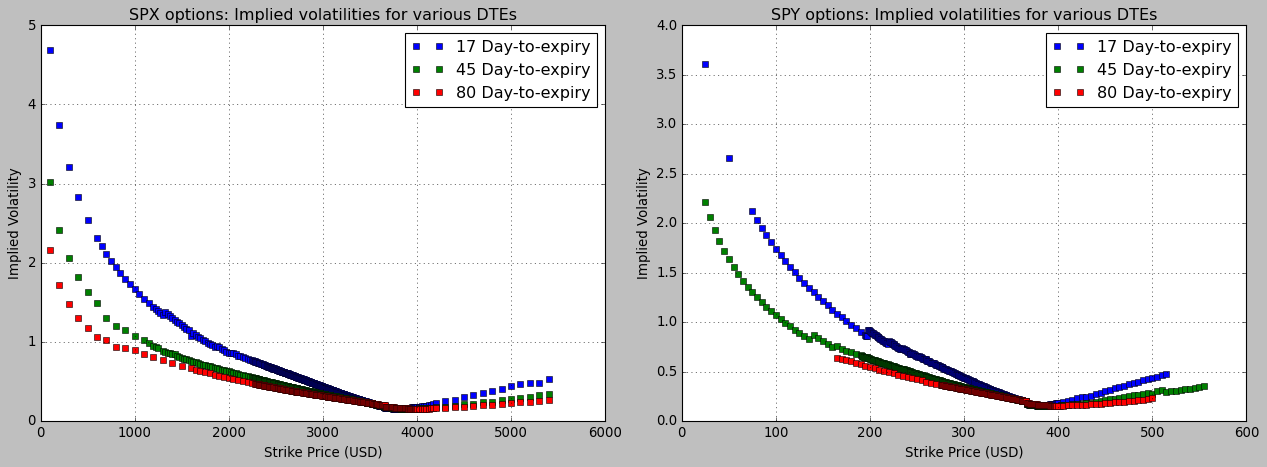

In [12]:
# Create subplots for SPX and SPY side by side
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# SPX options: market-implied volatilities
ax[0].set_title("SPX options: Implied volatilities for various DTEs")
for day_to_expiry, df_vol in implied_vol_dict_spx.items():
    ax[0].plot(
        df_vol["strike"],
        df_vol["impliedvol"],
        "s",
        label="{} Day-to-expiry".format(day_to_expiry),
    )
ax[0].grid()
ax[0].set_xlabel("Strike Price (USD)")
ax[0].set_ylabel("Implied Volatility")
ax[0].legend()

# SPY options: market-implied volatilities
ax[1].set_title("SPY options: Implied volatilities for various DTEs")
for day_to_expiry, df_vol in implied_vol_dict_spy.items():
    ax[1].plot(
        df_vol["strike"],
        df_vol["impliedvol"],
        "s",
        label="{} Day-to-expiry".format(day_to_expiry),
    )
ax[1].grid()
ax[1].set_xlabel("Strike Price (USD)")
ax[1].set_ylabel("Implied Volatility")
ax[1].legend()

# Save and show the combined plot
plt.tight_layout()
plt.savefig("Combined_market_vol_SPX_SPY_options.png")
plt.show()

# 4. Displaced-Diffusion Model Calibration


# 4.1 Displaced-Diffusion Model


In [15]:
def calculate_DD_vol_err(x, strikes, vols, S, r, sigma, T, options_type):
    err = 0.0
    for i, vol in enumerate(vols):
        if options_type[i] == "call":
            price = vanilla_option.displaced_diffusion_model(
                S, strikes[i], r, sigma, T, x[0]
            ).calculate_call_price()
        else:
            price = vanilla_option.displaced_diffusion_model(
                S, strikes[i], r, sigma, T, x[0]
            ).calculate_put_price()
        implied_vol = implied_volatility(S, strikes[i], r, price, T, options_type[i])
        err += (vol - implied_vol) ** 2
    return err

## 4.2 European Options (SPX)


In [17]:
DD_params_by_dte_dict = {}

for day_to_expiry, df_vol in implied_vol_dict_spx.items():
    rates = df_rates_processed.loc[int(day_to_expiry)]["rate_decimal"]
    T = float(day_to_expiry) / 365
    S = S_SPX
    sigma = np.interp(S, df_vol["strike"], df_vol["impliedvol"])

    initial_guess = [0.96]  # beta
    res = least_squares(
        lambda x: calculate_DD_vol_err(
            x,
            df_vol["strike"],
            df_vol["impliedvol"],
            S,
            rates,
            sigma,
            T,
            df_vol["options_type"],
        ),
        initial_guess,
        bounds=(0, 1),
    )
    DD_params_by_dte_dict[day_to_expiry] = {"sigma": sigma, "beta": res.x[0]}
DD_params_by_dte_dict

{'17': {'sigma': 0.17448532472572187, 'beta': 1.4984831507096636e-07},
 '45': {'sigma': 0.1849096526276905, 'beta': 1.0217360016894638e-06},
 '80': {'sigma': 0.19374721854522414, 'beta': 2.66133316452479e-13}}

## 4.2 American Options (SPY)


In [19]:
DD_params_by_dte_dict = {}

for day_to_expiry, df_vol in implied_vol_dict_spy.items():
    rates = df_rates_processed.loc[int(day_to_expiry)]["rate_decimal"]
    T = float(day_to_expiry) / 365
    S = S_SPY
    sigma = np.interp(S, df_vol["strike"], df_vol["impliedvol"])

    initial_guess = [0.96]  # beta
    res = least_squares(
        lambda x: calculate_DD_vol_err(
            x,
            df_vol["strike"],
            df_vol["impliedvol"],
            S,
            rates,
            sigma,
            T,
            df_vol["options_type"],
        ),
        initial_guess,
        bounds=(0, 1),
    )
    DD_params_by_dte_dict[day_to_expiry] = {"sigma": sigma, "beta": res.x[0]}
DD_params_by_dte_dict

{'17': {'sigma': 0.200905534391913, 'beta': 7.610217070515344e-07},
 '45': {'sigma': 0.1972176434869465, 'beta': 6.560495348301377e-09},
 '80': {'sigma': 0.2002402677797878, 'beta': 3.754537985023866e-08}}

# 5. SABR Model Calibration


# 5.1 SABR Model


In [22]:
def SABR_model(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta) ** 2) / 24) * alpha * alpha / (F ** (2 - 2 * beta))
        numer2 = 0.25 * rho * beta * nu * alpha / (F ** (1 - beta))
        numer3 = ((2 - 3 * rho * rho) / 24) * nu * nu
        VolAtm = alpha * (1 + (numer1 + numer2 + numer3) * T) / (F ** (1 - beta))
        sabrsigma = VolAtm
    else:
        z = (nu / alpha) * ((F * X) ** (0.5 * (1 - beta))) * np.log(F / X)
        zhi = np.log((((1 - 2 * rho * z + z * z) ** 0.5) + z - rho) / (1 - rho))
        numer1 = (((1 - beta) ** 2) / 24) * ((alpha * alpha) / ((F * X) ** (1 - beta)))
        numer2 = 0.25 * rho * beta * nu * alpha / ((F * X) ** ((1 - beta) / 2))
        numer3 = ((2 - 3 * rho * rho) / 24) * nu * nu
        numer = alpha * (1 + (numer1 + numer2 + numer3) * T) * z
        denom1 = ((1 - beta) ** 2 / 24) * (np.log(F / X)) ** 2
        denom2 = (((1 - beta) ** 4) / 1920) * ((np.log(F / X)) ** 4)
        denom = ((F * X) ** ((1 - beta) / 2)) * (1 + denom1 + denom2) * zhi
        sabrsigma = numer / denom

    return sabrsigma


def calculate_SABR_vol_err(x, strikes, vols, F, T, beta):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR_model(F, strikes[i], T, x[0], beta, x[1], x[2])) ** 2
    return err

## 5.2 European Options (SPX)


In [24]:
beta = 0.7
SABR_params_by_dte_dict = {}

for day_to_expiry, df_vol in implied_vol_dict_spx.items():
    rates = df_rates_processed.loc[int(day_to_expiry)]["rate_decimal"]
    T = float(day_to_expiry) / 365
    F = S_SPX * np.exp(rates * T)

    initial_guess = [0.02, 0.2, 0.1]  # alpha, rho, nu
    res = least_squares(
        lambda x: calculate_SABR_vol_err(
            x, df_vol["strike"], df_vol["impliedvol"], F, T, beta
        ),
        initial_guess,
    )
    SABR_params_by_dte_dict[day_to_expiry] = {
        "F": F,
        "alpha": res.x[0],
        "beta": beta,
        "rho": res.x[1],
        "nu": res.x[2],
    }
SABR_params_by_dte_dict

/var/folders/k1/7yl62fwx2879_758cjywcjrw0000gn/T/ipykernel_49492/1652073992.py:12: RuntimeWarning: invalid value encountered in scalar power
  zhi = np.log((((1 - 2 * rho * z + z * z) ** 0.5) + z - rho) / (1 - rho))
/var/folders/k1/7yl62fwx2879_758cjywcjrw0000gn/T/ipykernel_49492/1652073992.py:12: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2 * rho * z + z * z) ** 0.5) + z - rho) / (1 - rho))


{'17': {'F': 3662.664084743022,
  'alpha': 1.2122899805313736,
  'beta': 0.7,
  'rho': -0.3009002485424542,
  'nu': 5.459761384395847},
 '45': {'F': 3663.3762493669747,
  'alpha': 1.8165044322089068,
  'beta': 0.7,
  'rho': -0.4043017551686191,
  'nu': 2.790158328184338},
 '80': {'F': 3664.221472703759,
  'alpha': 2.140132608298422,
  'beta': 0.7,
  'rho': -0.5749338867759324,
  'nu': 1.84174697563188}}

## 5.3 American Options (SPY)


In [26]:
beta = 0.7
SABR_params_by_dte_dict = {}

for day_to_expiry, df_vol in implied_vol_dict_spy.items():
    rates = df_rates_processed.loc[int(day_to_expiry)]["rate_decimal"]
    T = float(day_to_expiry) / 365
    F = S_SPY * np.exp(rates * T)

    initial_guess = [0.02, 0.2, 0.1]  # alpha, rho, nu
    res = least_squares(
        lambda x: calculate_SABR_vol_err(
            x, df_vol["strike"], df_vol["impliedvol"], F, T, beta
        ),
        initial_guess,
    )
    SABR_params_by_dte_dict[day_to_expiry] = {
        "F": F,
        "alpha": res.x[0],
        "beta": beta,
        "rho": res.x[1],
        "nu": res.x[2],
    }
SABR_params_by_dte_dict

/var/folders/k1/7yl62fwx2879_758cjywcjrw0000gn/T/ipykernel_49492/1652073992.py:12: RuntimeWarning: invalid value encountered in scalar power
  zhi = np.log((((1 - 2 * rho * z + z * z) ** 0.5) + z - rho) / (1 - rho))


{'17': {'F': 366.0413953221589,
  'alpha': 0.6654021853245597,
  'beta': 0.7,
  'rho': -0.4118998606736283,
  'nu': 5.249981439124839},
 '45': {'F': 366.11256803322914,
  'alpha': 0.9081326349323565,
  'beta': 0.7,
  'rho': -0.4887794472282475,
  'nu': 2.72851634129598},
 '80': {'F': 366.1970384412155,
  'alpha': 1.1209243559875335,
  'beta': 0.7,
  'rho': -0.6329391710914177,
  'nu': 1.742224768224667}}

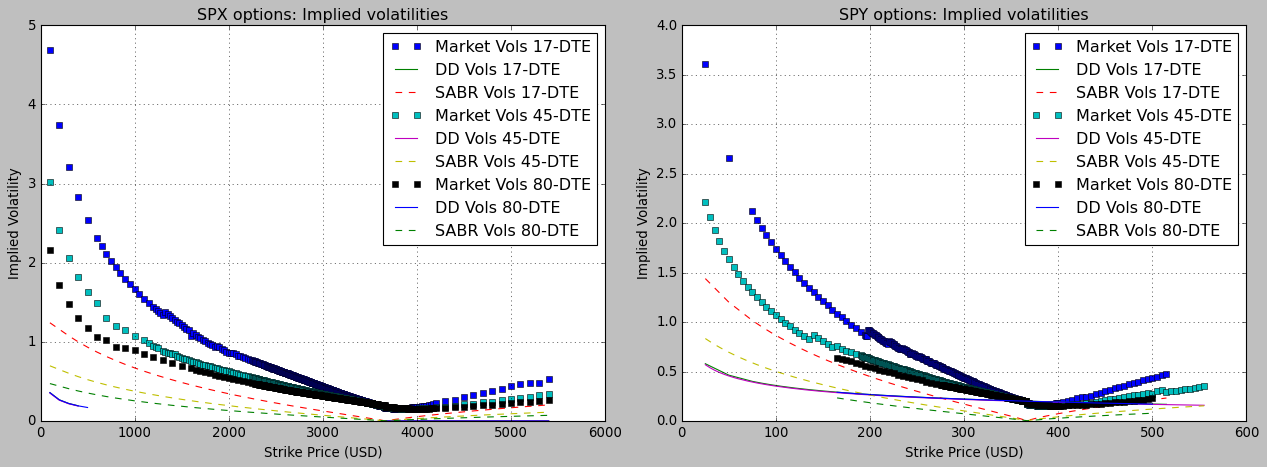

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Combine SPX implied volatility plots into one
ax[0].set_title("SPX options: Implied volatilities")
for day_to_expiry, df_vol in implied_vol_dict_spx.items():
    rates = df_rates_processed.loc[int(day_to_expiry)]["rate_decimal"]
    T = float(day_to_expiry) / 365
    params_dd = DD_params_by_dte_dict[day_to_expiry]
    params_sabr = SABR_params_by_dte_dict[day_to_expiry]
    beta = params_dd["beta"]
    sigma = params_dd["sigma"]
    F = S_SPX * np.exp(rates * T)

    # Calculate DD vols
    ddvols = []
    for i, K in enumerate(df_vol["strike"]):
        option_type = df_vol["options_type"][i]
        if option_type == "call":
            price = vanilla_option.displaced_diffusion_model(
                S, K, rates, sigma, T, beta
            ).calculate_call_price()
        else:
            price = vanilla_option.displaced_diffusion_model(
                S, K, rates, sigma, T, beta
            ).calculate_put_price()
        implied_vol = implied_volatility(S, K, rates, price, T, option_type)
        ddvols.append(implied_vol)

    # Calculate SABR vols
    sabrvols = [
        SABR_model(F, K, T, params_sabr["alpha"], beta, params_sabr["rho"], params_sabr["nu"])
        for K in df_vol["strike"]
    ]

    # Plot market, DD, and SABR vols
    ax[0].plot(df_vol["strike"], df_vol["impliedvol"], "s", label=f"Market Vols {day_to_expiry}-DTE")
    ax[0].plot(df_vol["strike"], ddvols, label=f"DD Vols {day_to_expiry}-DTE")
    ax[0].plot(df_vol["strike"], sabrvols, "--", label=f"SABR Vols {day_to_expiry}-DTE")

ax[0].grid()
ax[0].set_xlabel("Strike Price (USD)")
ax[0].set_ylabel("Implied Volatility")
ax[0].legend()

# Combine SPY implied volatility plots into one
ax[1].set_title("SPY options: Implied volatilities")
for day_to_expiry, df_vol in implied_vol_dict_spy.items():
    rates = df_rates_processed.loc[int(day_to_expiry)]["rate_decimal"]
    T = float(day_to_expiry) / 365
    params_dd = DD_params_by_dte_dict[day_to_expiry]
    params_sabr = SABR_params_by_dte_dict[day_to_expiry]
    beta = params_dd["beta"]
    sigma = params_dd["sigma"]
    F = S_SPY * np.exp(rates * T)

    # Calculate DD vols
    ddvols = []
    for i, K in enumerate(df_vol["strike"]):
        option_type = df_vol["options_type"][i]
        if option_type == "call":
            price = vanilla_option.displaced_diffusion_model(
                S, K, rates, sigma, T, beta
            ).calculate_call_price()
        else:
            price = vanilla_option.displaced_diffusion_model(
                S, K, rates, sigma, T, beta
            ).calculate_put_price()
        implied_vol = implied_volatility(S, K, rates, price, T, option_type)
        ddvols.append(implied_vol)

    # Calculate SABR vols
    sabrvols = [
        SABR_model(F, K, T, params_sabr["alpha"], beta, params_sabr["rho"], params_sabr["nu"])
        for K in df_vol["strike"]
    ]

    # Plot market, DD, and SABR vols
    ax[1].plot(df_vol["strike"], df_vol["impliedvol"], "s", label=f"Market Vols {day_to_expiry}-DTE")
    ax[1].plot(df_vol["strike"], ddvols, label=f"DD Vols {day_to_expiry}-DTE")
    ax[1].plot(df_vol["strike"], sabrvols, "--", label=f"SABR Vols {day_to_expiry}-DTE")

ax[1].grid()
ax[1].set_xlabel("Strike Price (USD)")
ax[1].set_ylabel("Implied Volatility")
ax[1].legend()

plt.tight_layout()
plt.savefig("Combined_SPX_SPY_vols.png")
plt.show()

Discuss how changing $\beta$ in the displaced-diffusion model and changing $\rho$ and $\nu$ in the SABR model affect the shape of the implied volatility smile.

**Answer:**
1. Effect of changing $\beta$ in the displaced-diffusion (DD) model

The parameter $\beta$ in the DD model controls how much of the volatility is attributed to the **underlying asset price** versus the **displacement**. In essence:
- When $\beta = 1$, the DD model reduces to the standard Black-Scholes model, meaning the volatility does not depend on the displacement and is purely a function of the log-normal distribution of asset prices.
- Lowering $\beta$ shifts the model toward a displaced framework, emphasizing the role of the **displacement** (i.e., the distance between the strike price and underlying asset price) in determining the implied volatility.

<u>Impact on the implied volatility smile</u>

- As $\beta$ decreases:
  - The smile becomes steeper for **out-of-the-money (OTM)** and **in-the-money (ITM)** options, as the DD model assigns more weight to the displacement. This allows the model to better capture market deviations from the log-normal assumption in the Black-Scholes model.
  - For **at-the-money (ATM)** options, the implied volatility remains relatively stable because the ATM region is less sensitive to changes in $\beta$.

- As $\beta$ increases:
  - The smile flattens, resembling the constant volatility assumption of the Black-Scholes model, particularly at OTM and ITM strikes.
  - The model fails to capture the steep curvature observed in the implied volatility smile, especially for shorter maturities.

2. Effect of changing $\rho$ in the SABR model

The parameter $\rho$ in the SABR model represents the correlation between the underlying asset's return and its volatility:
- $\rho > 0$: Indicates a **positive correlation**, meaning volatility increases as the asset price increases.
- $\rho < 0$: Indicates a **negative correlation**, meaning volatility increases as the asset price decreases. This is commonly observed in equity markets, as downward price movements are often associated with higher volatility (the leverage effect).

<u>Impact on the implied volatility smile</u>

- As $\rho$ becomes more negative:
  - The smile becomes more skewed to the left, with higher implied volatility for lower strikes (OTM puts).
  - This aligns with market observations where OTM puts are more expensive due to higher demand for downside protection.

- As $\rho$ becomes more positive:
  - The smile becomes more symmetric, with less skewness to the left, as positive correlation reduces the effect of volatility clustering during price declines.

3. Effect of changing $\nu$ in the SABR model

The parameter $\nu$ in the SABR model represents the **volatility of volatility**, capturing the stochastic nature of the volatility process.

<u>Impact on the implied volatility smile</u>

- As $\nu$ increases:
  - The smile becomes more pronounced, with steeper curvature at both OTM and ITM strikes.
  - The model captures the additional uncertainty in volatility, which widens the range of implied volatilities across strikes, especially for short-term options.

- As $\nu$ decreases:
  - The smile flattens, as lower volatility of volatility implies a more stable volatility environment. This limits the model's ability to explain steep smiles observed in highly volatile markets.

\underline{Summary}
| **Parameter** | **Effect on implied volatility smile**                                                                                                                                                     |
|---------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| $\beta$     | Lower $\beta$: Steeper smile (OTM and ITM), better fit to market data.<br>Higher $\beta$: Flatter smile, resembling Black-Scholes assumption.                         |
| $\rho$      | Negative $\rho$: Left-skewed smile (higher IV for OTM puts). Positive $\rho$: More symmetric smile.                                                                |
| $\nu$       | Higher $\nu$: Steeper curvature in the smile (more pronounced OTM and ITM volatility). Lower $\nu$: Flatter smile, less sensitivity to strike price.                |

These parameters, when calibrated appropriately, allow the displaced-diffusion and SABR models to better fit real market data, addressing the limitations of constant-volatility models like Black-Scholes.